

# Example Project Report: How fast do I need to speed to escape the police?
**Name:** Peanut Butter Ives

*(While this example project demonstrates the important components of a project report, this example project was assessed as requiring Major Revisions. Note that it not meant to be an example related directly to any of our project topics.)*

## Introduction

In this project I use Euler's method to investigate how fast I would need to drive to escape the police. The specific situation I investigate is one where I speed past an at-rest police car, with the rule that if the police car can't catch me within 2 minutes, they give up. Knowing that a typical police car can travel at last as fast as 60 m/s (216 km/h), I investigate constant speeds for my car from 40 - 60 m/s. 

**Research Question:** How fast do I need to drive past an at-rest police car such that it can't catch me within 2 minutes?

## Physics model and assumptions

In setting up the model represented by the physics simulation, we make the following assumptions:

1. I will be driving at constant speed, $v_{me}$.
1. The police car starts at rest and begins accelerating 5 seconds after I pass it. This seems like a reasonabe delay between when I drive by and when the car start accelerating.
1. The police car accelerates at a rate that would get them from 0-60 mph is 6 seconds. I'm going to assume that the police car can maintain that acceleration up to a maximum speed of 140 mph [1].
1. If the police car can't catch me within 2 minutes, they give up (Grand Theft Auto Rules [2])

Since my speed will be constant, the equation governing my motion is simply:

$$x_{me}=v_{me}t.$$ 

The police car's motion is governed by two different equations. The first is governed entirely by acceleration since the car starts at rest, and then the second describes the motion once it has reached its final speed:

$$x_{police,1} = \frac{1}{2}at^2$$
$$x_{police,2} = x_{police,1,max}+v_{max}t$$

Here, $x_{police,1,max}$ is the position when the police car first reaches the maximum speed using the equation for $x_{police,1}$, and $v_{max}$ is the maximum speed. In Euler's method this will be easy to model since I will simply change the equation for acceleration once the speed hits the maximum.

## Investigating the situation for my car travelling at 50 m/s

For an initial investigation, I look at what happens when I am travelling at 50 m/s, which is the midpoint between the minumum and maximum constant speeds (40 - 60 m/s) that I will investigate for my car.

**Code block summary:** In the following code block, I use Euler's method to model the motion of my car and the police car. I set the t = 0 and x = 0 to the moment when I pass the police car, and then the police car starts moving 5 seconds later. The police car accelerates at 4.47 m/s² until reaching its maximum speed of 62.6 m/s, while I maintain a constant speed of 50 m/s. Since I escape if the chase is longer than 2 minutes, I only need to run the simulation for that long. The code stores time, position and speed data in arrays for graphing, and I don't store my speed data since it's constant. At the end, I plot comparing both cars' positions over the entire 2 minutes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Given data:
t_max = 120             # s     - Time before the police officer gives up
v_police_max = 62.6     # m/s   - Police car maximum speed, about 225 km/h (140 mph)
accel_start_time = 5    # s     - Delay before police car starts moving
accel_max_police = 4.47 # m/s^2 - Acceleration of police car, ~ 0 to 60mph in 6 seconds
dt = 0.1                # s     - Small time step for Euler's method
v_me = 50               # m/s   - My constant speed

# Initial states
t0 = 0
x0_me = 0     # m - My initial position
x0_police = 0 # m - Initial position of the police car
v0_police = 0 # m/s - Initial police car speed
a0_police = 0 # m/s^2 - Police car starts at rest

# Array size
n_steps = int((t_max - t0) / dt) + 1

# Create arrays to store information
t = np.zeros(n_steps)
x_me = np.zeros(n_steps)
x_police = np.zeros(n_steps)
v_police = np.zeros(n_steps)
a_police = np.zeros(n_steps)

# Fill arrays with initial states
t[0] = t0
x_me[0] = x0_me 
x_police[0] = x0_police
v_police[0] = v0_police
a_police[0] = a0_police


for i in range(1, n_steps):
    
    # All information is updated with respect to the previous step
    
    # Update the positions of both cars
    x_me[i] = x_me[i-1] + v_me * dt
    x_police[i] = x_police[i-1] + v_police[i-1] * dt
    
    # Update police car speed - Note we only turn acceleration on when needed
    v_police[i] = v_police[i-1] + a_police[i-1] * dt
    
    # Ensure police car cannot go faster than max speed
    if v_police[i] > v_police_max:
        v_police[i] = v_police_max
    
    # Determine acceleration used in the next step
    if t[i-1] < accel_start_time:
        a_police[i] = a0_police
    elif v_police[i] < v_police_max:
        a_police[i] = accel_max_police
    else:
        a_police[i] = 0.0   
    
    # Update time
    t[i] = t[i-1] + dt

**Code block summary:** This code block creates a plot showing position vs time for both me and the police car when my speed is v = 50 m/s.

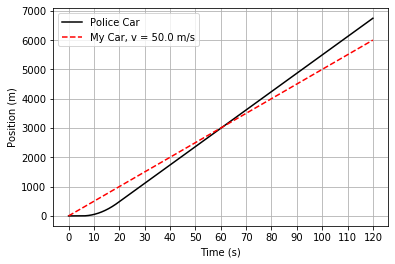

In [2]:
# Plot the results
plt.plot(t, x_police, label='Police Car', color='black')
plt.plot(t, x_me, label=f'My Car, v = {v_me:.1f} m/s', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, int(t_max) + 1, 10))
plt.show()

**Fig 1.** This plot shows that the police car catches up to me at approximately t = 60 seconds when my constant speed is 50.0 m/s.

The graph above shows how the simulation works for travelling at 50 m/s. Here the police car catches up to me in approximately 60 seconds, so I don't escape. In the next investigation I will look at speeds higher than 50 m/s.

## Investigating the situation for my car travelling from 40 - 60 m/s

In this section I look at a range of speeds from 40 to 60 m/s to figure out how fast I need to be driving to escape the police.

**Code block summary:** The following code block is based on the earlier code block, and reuses many of the same variables. It introduces an array `v_me_array`, to provide my vehicle speeds over which to loop to figure out the lowest speed at which I can still escape in 2 minutes. These speeds range from 40 - 60 m/s. To accomplish all of this, I nest the loop from the previous code block inside a loop over all the speeds in `v_me_array`. I also change the behaviour of my original time loop to break if the police catch me, and store the time at which this happened into, an array `caught_times` which I will use in the next code block

In [3]:
# All the speeds we will loop over
v_me_array = np.linspace(40, 60, 21) 

# Store the times at which the car is caught
caught_times = np.zeros_like(v_me_array)

# Loop over each v_me, and use i_v for the index needed later for caught_times
for i_v, v_me in enumerate(v_me_array):

    # Re-create arrays to store information
    t = np.zeros(n_steps)
    x_me = np.zeros(n_steps)
    x_police = np.zeros(n_steps)
    v_police = np.zeros(n_steps)
    a_police = np.zeros(n_steps)

    # Fill arrays with initial states
    t[0] = t0
    x_me[0] = x0_me 
    x_police[0] = x0_police
    v_police[0] = v0_police
    a_police[0] = a0_police


    for i in range(1, n_steps):

        # All information is updated with respect to the previous step

        # Update the positions of both cars
        x_me[i] = x_me[i-1] + v_me * dt
        x_police[i] = x_police[i-1] + v_police[i-1] * dt

        # Update police car speed - Note we only turn acceleration on when needed
        v_police[i] = v_police[i-1] + a_police[i-1] * dt

        # Ensure police car cannot go faster than max speed
        if v_police[i] > v_police_max:
            v_police[i] = v_police_max

        # Determine acceleration used in the next step
        if t[i-1] < accel_start_time:
            a_police[i] = a0_police
        elif v_police[i] < v_police_max:
            a_police[i] = accel_max_police
        else:
            a_police[i] = 0.0   

        # Update time
        t[i] = t[i-1] + dt
        
        # If the police car catches up, store relevant information and 
        # move onto next speed
        if x_police[i] >= x_me[i]:
            
            # Store the caught time for this speed 
            caught_times[i_v] = t[i]
            
            # End the time loop because I did not get away
            break

**Code block summary:** After storing the times at which the police catch me in the array `caught_times` (or leaving the value as `0.0` when I'm not caught) we use the code block below to sort the times, and corresponding speeds of my car into two sets of arrays, the ones when I get caught and the ones when I get away. The answer to how fast do I need to drive to escape the police will be answered by the first element in the `v_me_escaped` array, which consists of all the speeds that I found when I escaped. The output of this cell is to print out that escape speed.

In [4]:
# Initialize empty lists to store results
caught_times_filtered = []  # Only the non-zero values from caught_times
escaped_times = []          # The times at which I escape
v_me_caught = []            # v_me values when caught_times != 0
v_me_escaped = []           # v_me values when caught_times == 0

# Loop through both arrays at the same time
for i in range(len(caught_times)):
    if caught_times[i] != 0:  # If caught_times value is non-zero
        caught_times_filtered.append(caught_times[i])
        v_me_caught.append(v_me_array[i])
    else:  # If caught_times value is zero
        v_me_escaped.append(v_me_array[i])  
        escaped_times.append(t_max) # If escaped
        
# Provide feedback on my lowest speed at which I escaped
print(f"My lowest speed at which I escaped was {v_me_escaped[0]} m/s")
        
# To make our graph below continuous, we also append the lowest speed 
# at which I escape to the 'caught' lists
caught_times_filtered.append(escaped_times[0])
v_me_caught.append(v_me_escaped[0])

My lowest speed at which I escaped was 57.0 m/s


**Code block summary:** In the code block below I plot the time that I'm caught vs my speed, using a dashed red line to indicate when I'm caught and a solid black line to indicate speeds at which I get away.

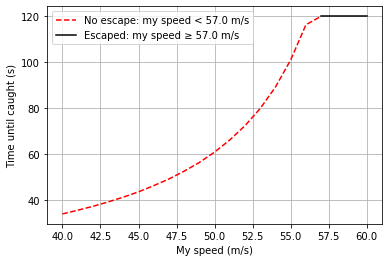

In [5]:
# Plot time caught vs my speed
plt.plot(v_me_caught, caught_times_filtered, 
         label=f'No escape: my speed < {v_me_escaped[0]} m/s', color='red', linestyle='--')
plt.plot(v_me_escaped, escaped_times, label=f'Escaped: my speed ≥ {v_me_escaped[0]} m/s', color='black')
plt.xlabel('My speed (m/s)')
plt.ylabel('Time until caught (s)')
plt.grid(True)
plt.legend()
plt.show()

**Fig 2.** Plot showing the times at which the police catch me (red dashed line) within 120 seconds, which is all of my speeds lower than 57 m/s. It also shows that I get away for speeds ≥ 57 m/s (black solid line).

## Summary of findings

This simulation shows that I have to go really fast to escape the police within two minutes. Anything less than 57 m/s (204.4 km/h), and the police will catch up in under 2 minutes, as shown in Fig 2. This plot shows that they don't catch up within 120 seconds once I am going 57 m/s or faster, but they can easily catch at lower speed than that.

**Limitations:** This model of police behaviour has significant limitations. It's hard to imagine that outside of grand theft auto rules, the police would stop chasing me after 2 minutes, especially if they were that close. But still, this is a good piece of evidence that if you want to avoid the police, you probably have to drive faster than them. The 5-second head start on its own is not going to be enough.

**Next steps:** I think my next steps in this project would be to incorporate the acceleration of my car into the simulation, so that when I notice the police car start to accelerate that I would also accelerate. I could investigate the impact of different combinations of initial and maximum speeds, as well as different accelerations for my car. Alternatively, I could perform an investagation where the police car acceleration is much more realistic based on a limited power output from the police car engine reducing the acceleration at higher speeds.

## Acknowledgements

This example project is modified from a 2024 version authored by TA Aaron Kraft and edited by Joss Ives. Generative AI was used to brainstorm multiple different approaches of how to turn the police car acceleration on and off again. 

## References

1: https://stillwater.furymotors.com/blogs/4923/how-fast-is-the-dodge-charger-police-car/

2: https://en.wikipedia.org/wiki/Grand_Theft_Auto

## Appendix 1: Code validation

### A1.1: Checking that the position vs time curve look as expected

The first way I thought of to check that my code was to plots speed vs time curves to go with my position vs time curves from Fig 1. This should show much more clearly when the police car starts moving, that it shows constant acceleration until it gets to its maximum speed, and then maintain constant speed after that. My graph shows all of these features. Yes!


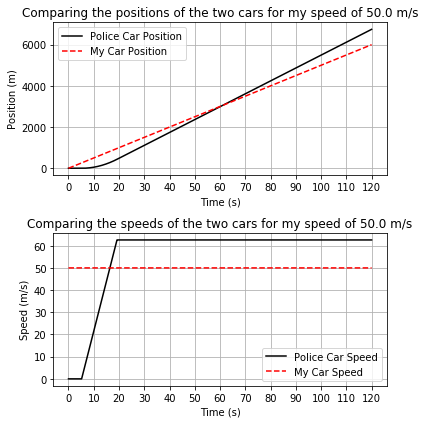

In [6]:
dt = 0.1
v_me = 50

# Array size
n_steps = int((t_max - t0) / dt) + 1

# Create arrays to store information
t = np.zeros(n_steps)
x_me = np.zeros(n_steps)
v_me_array = np.zeros(n_steps)
x_police = np.zeros(n_steps)
v_police = np.zeros(n_steps)
a_police = np.zeros(n_steps)

# Fill arrays with initial states
t[0] = t0
x_me[0] = x0_me 
v_me_array[0] = v_me 
x_police[0] = x0_police
v_police[0] = v0_police
a_police[0] = a0_police


for i in range(1, n_steps):
    
    # All information is updated with respect to the previous step
    
    # Update the positions of both cars
    x_me[i] = x_me[i-1] + v_me * dt
    x_police[i] = x_police[i-1] + v_police[i-1] * dt
    
    # Update police car speed - Note we only turn acceleration on when needed
    v_police[i] = v_police[i-1] + a_police[i-1] * dt
    
    # Ensure police car cannot go faster than max speed
    if v_police[i] > v_police_max:
        v_police[i] = v_police_max
        
    v_me_array[i] = v_me
    
    # Determine acceleration used in the next step
    if t[i-1] < accel_start_time:
        a_police[i] = a0_police
    elif v_police[i] < v_police_max:
        a_police[i] = accel_max_police
    else:
        a_police[i] = 0.0   
    
    # Update time
    t[i] = t[i-1] + dt
    
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# First subplot: positions of both cars
ax[0].plot(t, x_police, label='Police Car Position', color='black')
ax[0].plot(t, x_me, label='My Car Position', color='red', linestyle='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Position (m)')
ax[0].set_title(f"Comparing the positions of the two cars for my speed of {v_me:.1f} m/s")
ax[0].legend()
ax[0].grid(True)
ax[0].set_xticks(range(0, int(t_max) + 1, 10))

# Second subplot: speeds of both cars
ax[1].plot(t, v_police, label='Police Car Speed', color='black')
ax[1].plot(t, v_me_array, label='My Car Speed', color='red', linestyle='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Speed (m/s)')
ax[1].set_title(f"Comparing the speeds of the two cars for my speed of {v_me:.1f} m/s")
ax[1].legend()
ax[1].grid(True)
ax[1].set_xticks(range(0, int(t_max) + 1, 10))

plt.tight_layout()
plt.show()

### A1.2: Confirming police car motion agrees with expectations from kinematics equations

*(Please note that for by-hand calculations, you are welcome to either write them up in markdown or include pictures of actual hand-written notes like I have done.)*

To confirm that my simulation is behaving as expected, I use kinematics equations to figure out (see below) that the police car should travel 6761.7m in the 120 second of the chase. Because I need to travel further than this in 120 seconds to get away, I can use this distance to calculate my critical escape speed, which is 6761.7m/120s = 56.3m/s. This is consistent with my findings in this project report where I do not escape when driving 56 m/s, but do escape when driving 57 m/s. That gives me a lot of confidence that my simulation is behaving correctly.

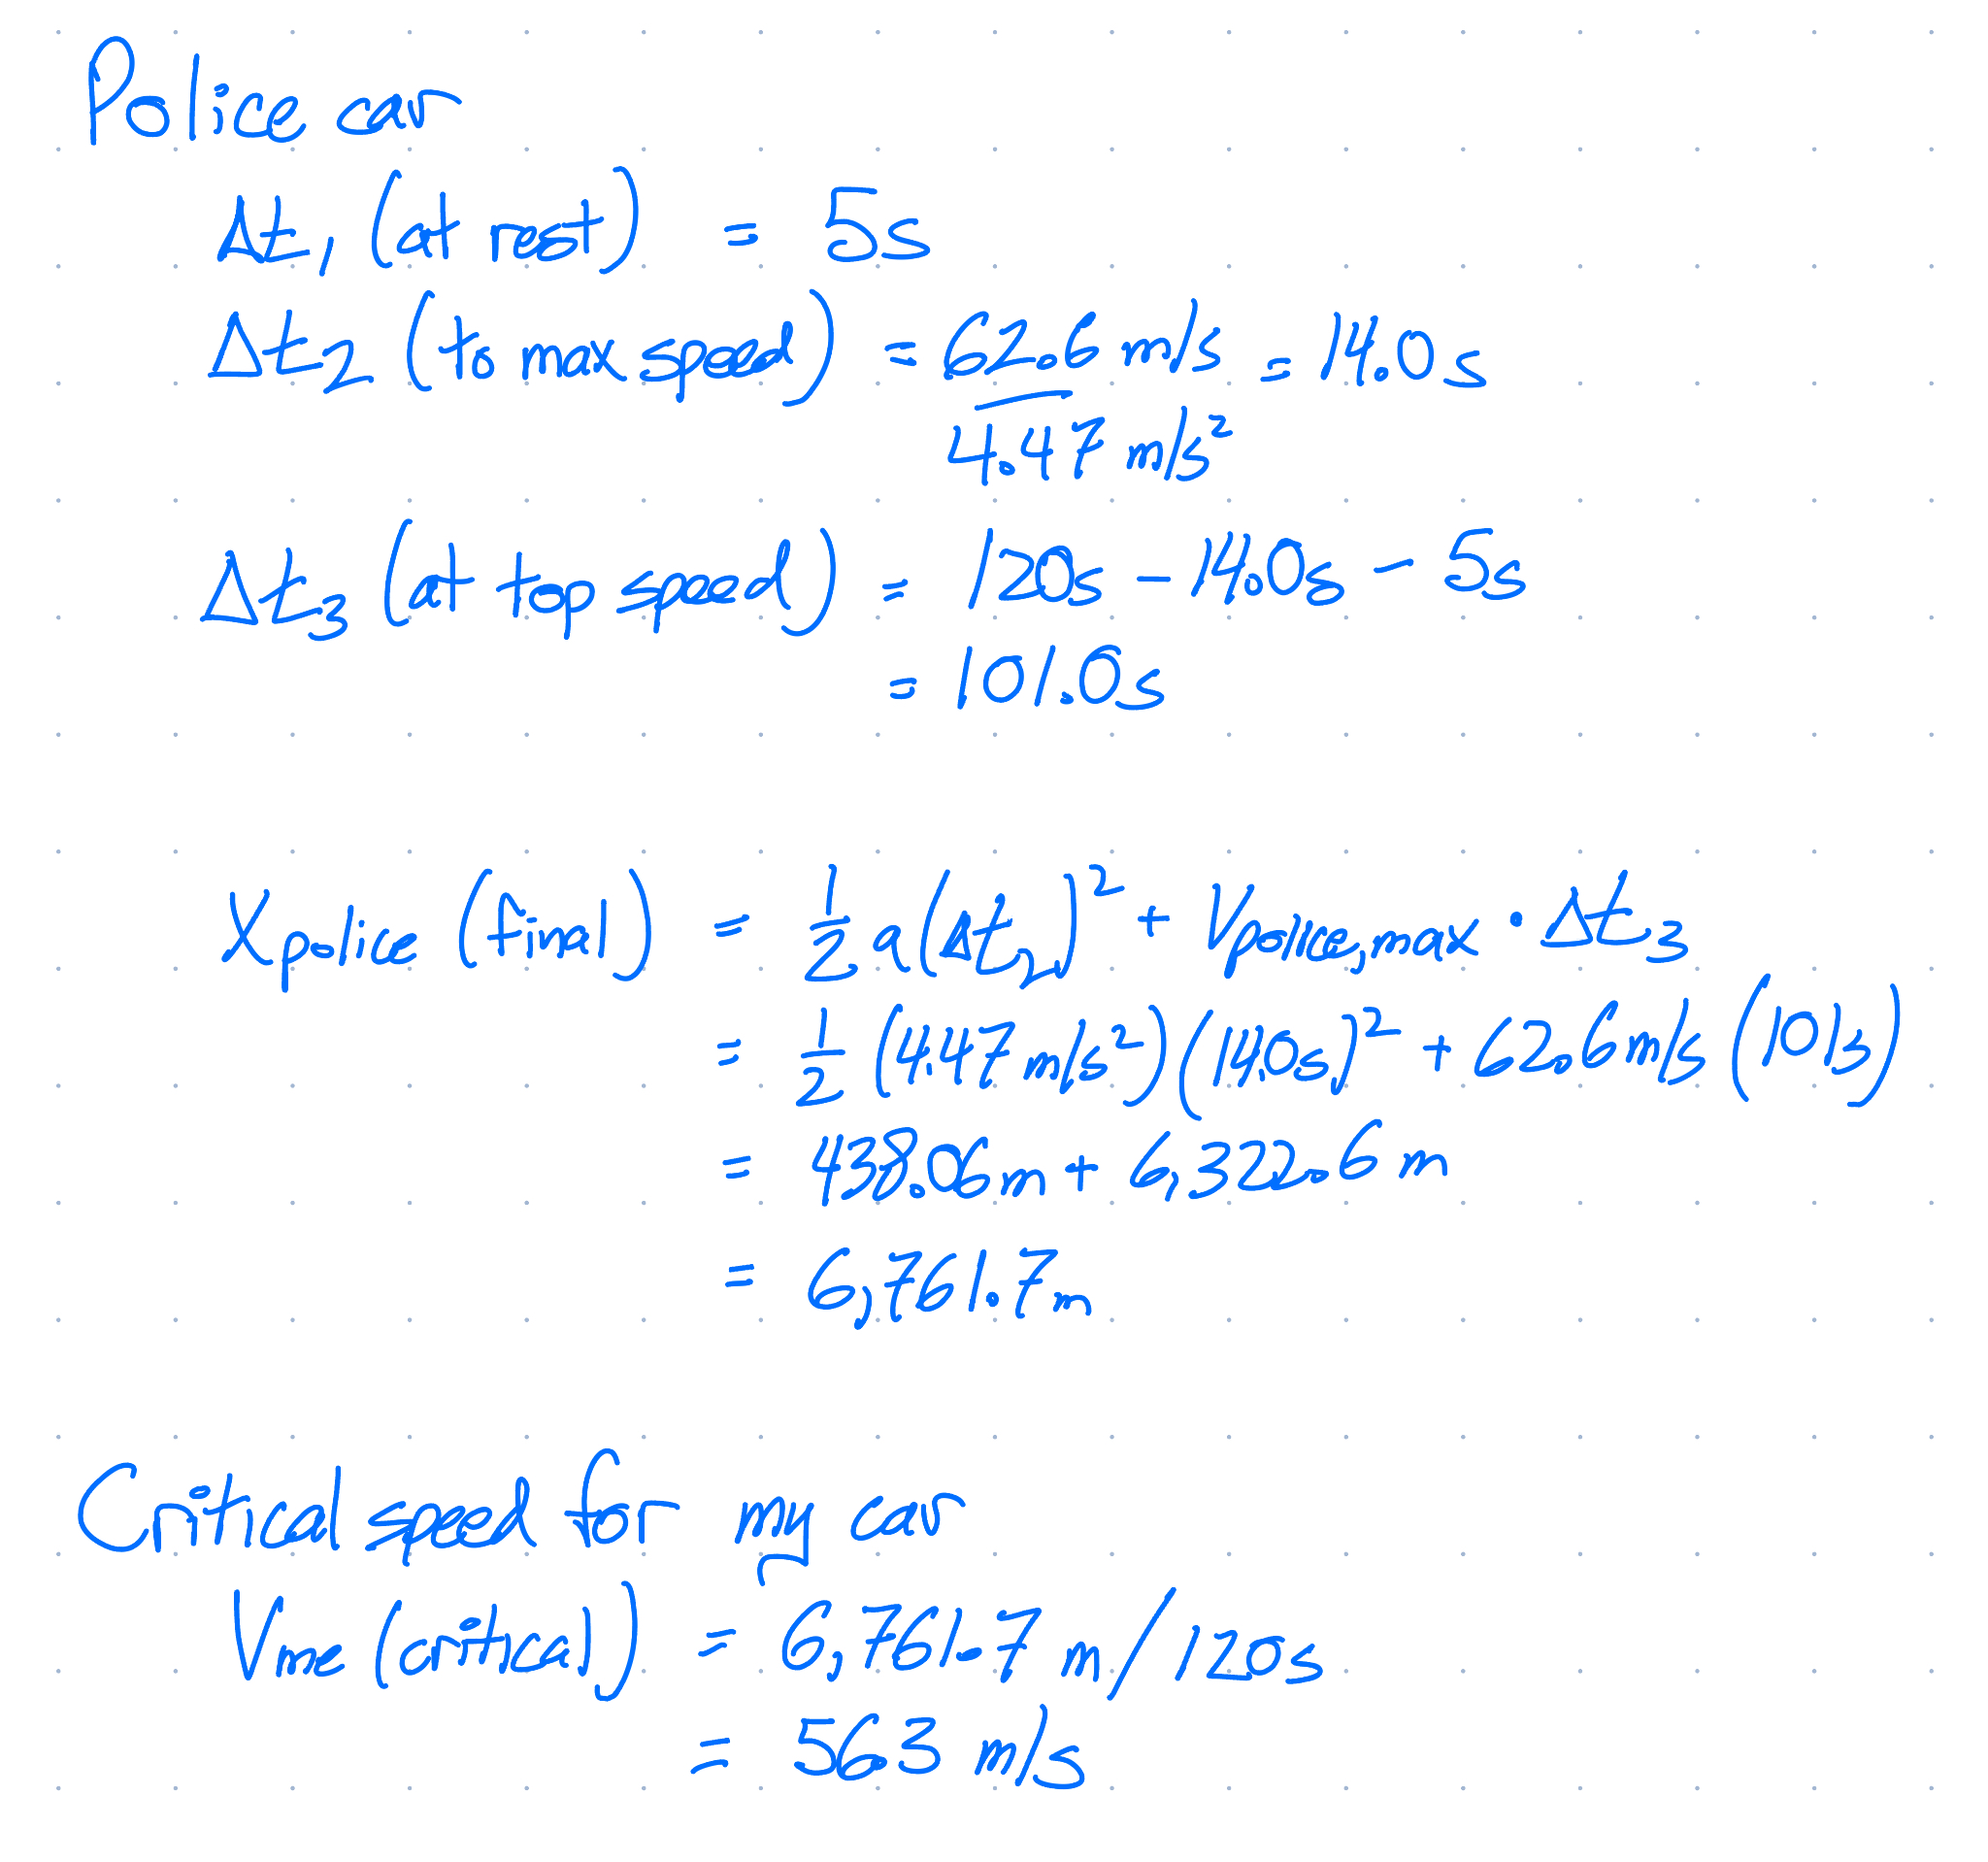

### A1.3: Checking sensitivity to the size of `dt`

In checking my calculations from Appendix A1.2, I noticed that the distance that the police car was travelling in 120 seconds from my code was 6745.0 m, not 6761.7 m as calculated by hand above. Understanding that this might be a result of the `dt` step size that I used, I reran my code for the police car only and printed out the distance travelled by the police car for `dt` values of 0.1, 0.01 and 0.001 s. As you can see below, the difference between the values from my code and from by-hand calculations go from nearly 17 meters to approximately 1 meter when `dt = 0.001s`, which also gives me a lot of confidence that my code is behaving correctly and that the accuracy of my calculations is limited by how small I make `dt`.

In [7]:
# Given data:
t_max = 120             # s     - Time before the police officer gives up
v_police_max = 62.6     # m/s   - Police car maximum speed, about 225 km/h (140 mph)
accel_start_time = 5    # s     - Delay before police car starts moving
accel_max_police = 4.47 # m/s^2 - Acceleration of police car, ~ 0 to 60mph in 6 seconds

# Initial states
t0 = 0
x0_police = 0 # m - Initial position of the police car
v0_police = 0 # m/s - Initial police car speed
a0_police = 0 # m/s^2 - Police car starts at rest

print("Police car final positions after 120s, based on size of dt:")

for dt in [0.1, 0.01, 0.001]:
    
    # Array size
    n_steps = int((t_max - t0) / dt) + 1

    # Create arrays to store information
    t = np.zeros(n_steps)
    x_police = np.zeros(n_steps)
    v_police = np.zeros(n_steps)
    a_police = np.zeros(n_steps)

    # Fill arrays with initiaal states
    t[0] = t0
    x_police[0] = x0_police
    v_police[0] = v0_police
    a_police[0] = a0_police

    for i in range(1, n_steps):

        # All information is updated with respect to the previous step

        # Update the positions of both cars
        x_police[i] = x_police[i-1] + v_police[i-1] * dt

        # Update police car speed - Note we only turn acceleration on when needed
        v_police[i] = v_police[i-1] + a_police[i-1] * dt

        # Ensure police car cannot go faster than max speed
        if v_police[i] > v_police_max:
            v_police[i] = v_police_max

        # Determine acceleration used in the next step
        if t[i-1] < accel_start_time:
            a_police[i] = a0_police
        elif v_police[i] < v_police_max:
            a_police[i] = accel_max_police
        else:
            a_police[i] = 0.0   

        # Update time
        t[i] = t[i-1] + dt

    print (f"• x(final) = {x_police[-1]:.2f} m/s for dt = {dt}")

Police car final positions after 120s, based on size of dt:
• x(final) = 6745.01 m/s for dt = 0.1
• x(final) = 6759.09 m/s for dt = 0.01
• x(final) = 6760.57 m/s for dt = 0.001


## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

Honestly, I didn't extend my coding knowledge very much in this project beyond learning how to use the np.linspace function. I was surprised how long it took me to go from the simulation that I used to make Fig 1 to the one that let me make Fig 2. I made a lot of small mistakes in this part of the investigation.

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

I was really happy once I figured out how to split caught_times and v_me_array into two sets of arrays so that I could make a plot that showed the speeds at which I got caught and the ones at which I got away. I realize now that I probably could have done a better job using descriptive variable names. I initially made some short variable names and then half-way through working on the project started updating some of them to be more descriptive. The problem was that every time I tried to update my variable names, it would cause new errors and I got tired of trying to fix the errors.

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

The physics in this simulation is really simple and I don't think my investigation is very complex. It would have been a better project if I varied more variables or introduced some additional physics like the power limitation on acceleration.

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

I like the story that I built for the simulation and was happy that I could use video game logic in a sort of real world situation. Other than investigating more variables, I want to better understand why my second graph has the sharp bend from 56 to 57 m/s.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

I really like my second graph. I used f-strings in my legend so that if I changed any of the variables, everything would update. I also think the graph communicates when I first escape really well because of the legend.

I'm a bit worried that my project write-up is too short.

## Appendix 3: Referee report

| Criteria                    | Ratings            | Comments   |
|:---|:--|:---|
| Simulation and simulation physics | Revision required | Some of the assumptions are clearly explained but the realism of the police car acceleration being constant throughout is not well-established and extremely unrealistic.   |
| Coding                      | No revision required | A reasonable effort was put in to use variables in many aspects of the plots (legends) so that changes to the parameters of the simulation will dynamically update the graphs. Assuming you will extend yourself a bit more on the coding side when you extend your investigation further, the coding practices should meet expectations. |
| Communication of investigation | Revision required | Given the quality of investigation, the research question is asked, answered, and supported. Revision is needed for Fig 1, which is supposed to be a multi-panel plot showing the behavior of the simulation. The multi-panel plot you included in Appendix A.1 is a great example of what should have been to show the behaviour of your simulation using a mult-panel plot. Overall, your captions could provide a bit more context and careful attention to the take-home message to the reader to help them better communicate your findings and stand more on their own. |
| Quality of investigation     | Revision required | The code validation appendices were well done. However, the overall investigation itself is not quite ambitious enough. Ideally, your investigation should investigate your outcome (the time at which you are caught or if you escaped) using the phase-space created by at least two independent variables---yours has just one, your speed, but you should vary at least one other variable with your speed. Either of the next steps you described are of an ambition level more appropriate to what we are looking for.  |
| Reflection                   | Revision recommended | Overall, the reflections demonstrate reasonable effort. It would have been good to provide a bit more detail in the Coding Approaches (A) reflection regarding which aspects of the project were most effortful to you.  |
| **Editorial Decision**           | **Major Revisions**             | **Overall, this project needs a bit more ambition to bring it up to Publish levels.**      |
